In [1]:
from firedrake import *
import numpy as np
import matplotlib.pyplot as plt
from firedrake.pyplot import triplot 
import pyvista as pv
from firedrake import max_value
from firedrake.adjoint import *
from firedrake.pyplot import quiver
from pyadjoint.tape import get_working_tape

In [2]:
# Configurar los parámetros del solver lineal
solver_parameters = {
    "ksp_type": "gmres",  # Tipo de solver (GMRES es común para sistemas no simétricos)
    "pc_type": "lu",      # Precondicionador (LU es directo y robusto)
    "ksp_rtol": 1e-9,     # Tolerancia relativa
    "ksp_atol": 1e-11,    # Tolerancia absoluta
    "ksp_max_it": 1000,   # Número máximo de iteraciones
}

Para el desarrollo de FEM, la idea inicial corresponde a resolver el equivalente a la ley de Hooke:

\begin{equation*}
\mathbf{KU} = F
\end{equation*}

En el caso de interés, se procede a aplicar FEM para el análisis mecánico de una pieza, inicialmente se emplea Cauchy stress tensor $\sigma$:

\begin{equation*}
\mathbf{\sigma} = \lambda \mathrm{tr(\varepsilon)} \mathbf{I} + 2 \mu \varepsilon
\end{equation*}

En donde $\mathbf{\varepsilon}$ corresponde al tensor de tensión (strain) definido a parotir del gradiente de deformación $\nabla \mathbf{u}$:

\begin{equation*}
\mathbf{\varepsilon} = \frac{1}{2} \left(\nabla \mathbf{u} + (\nabla \mathbf{u})^\mathrm{T} \right)
\end{equation*}

A su vez, $\lambda$ y $\mu$ son los parámetros de Lame que pueden ser expresados en términos del módulo de Young $E$ y el radio de Poisson $\nu$:

\begin{equation*}
\lambda = \frac{E\nu}{(1+\nu)(1-2\nu)}, \quad \mu = \frac{E}{2(1+\nu)} 
\end{equation*}

Estos parámetros son descritos para casos en 3D, para el escenario en 2D se requiere realizar una corrección debido a la falta de planos, corresponde a:
\begin{equation*}
\lambda^* = \frac{2\lambda\mu}{\lambda + 2\mu}
\end{equation*}

Por consiguiente el tensor de Cauchy se corrige como:
\begin{equation*}
\mathbf{\sigma} = \lambda^* \mathrm{tr(\varepsilon)} \mathbf{I} + 2 \mu \varepsilon
\end{equation*}

El problema mecánico visto desde una perspectiva variacional se establece como:

\begin{equation*}
\int_\Omega \sigma \: : \nabla v dx = \int_\Omega f\cdot v dx + \int_{\partial \Omega_T} T\cdot v ds 
\end{equation*}

Donde $T = \sigma \cdot n$

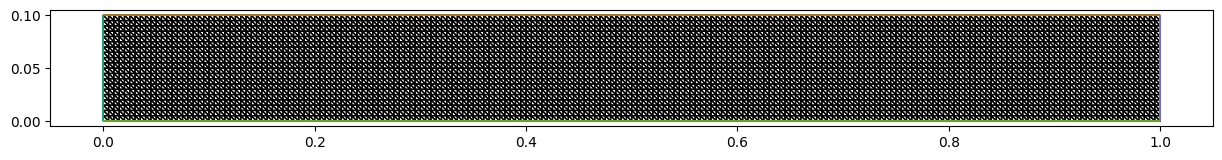

In [7]:
L = 1 # m
H = 0.1 # m
Nx = 200
Ny = 20
mesh = RectangleMesh(Nx, Ny, L, H)

# Graficar la malla
fig, ax = plt.subplots(figsize=(15,7))
triplot(mesh, axes=ax)
ax.set_aspect('equal')  # Mantiene la escala
plt.show()


In [ ]:
def eps(v):
    return sym(grad(v))


def sigma(v):
    return lmbda*tr(eps(v))*Identity(2) + 2.0*mu*eps(v)

# Structural Steel
E = Constant(2e11) # GPA
nu = Constant(0.3) # According to google
g = 9.8066 # m/s²
rho = 7850 # kg/m³
model = "plane_stress"

mu = E/(2*(1+nu))
lmbda = E*nu/((1+nu)*(1-2*nu))
if model == "plane_stress":
    lmbda = 2*mu*lmbda/(lmbda+2*nu)
    print("2D Behavior: Plane Stress")

# Fuctional Space

V = VectorFunctionSpace(mesh, 'Lagrange', degree = 3) # Continous Galerkin, second order
du = TrialFunction(V) # Displacement differential
v = TestFunction(V) # Test function

dx = dx(degree = 3) # Improve gdl

# Force due to weight
f_w = Constant((0, -g*rho))
F_ext = as_vector([0,-1e8])

# Variational Form due to weight
L_weight = inner(f_w, v)*dx 
L_ext = dot(F_ext, v)*ds(2)

# Weak method

a = inner(sigma(du), eps(v))*dx
l = L_weight + L_ext


2D Behavior: Plane Stress


In [5]:
bc = DirichletBC(V, Constant((0.,0.)), 1) # Left boundary condition

# Solver
u = Function(V, name="Displacement")
solve(a == l, u, bc)

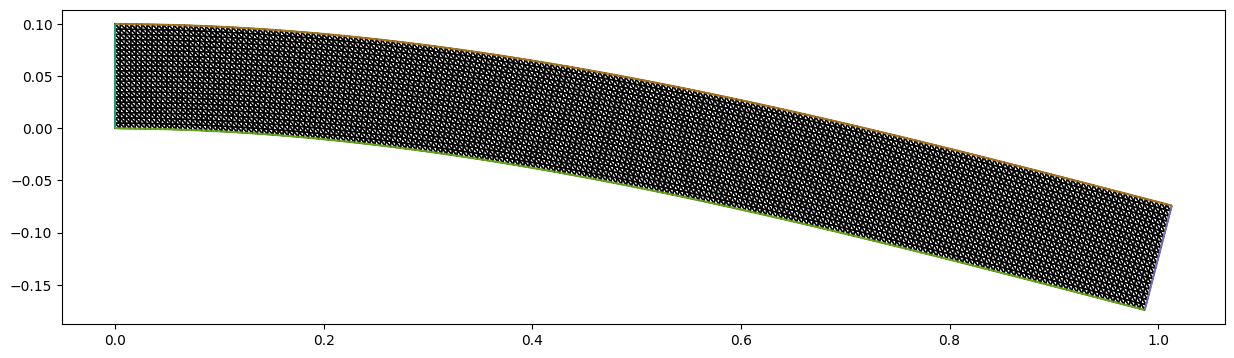

In [6]:
displaced_coordinates = interpolate(SpatialCoordinate(mesh) + u, V) # Amplificación de desplazamiento
displaced_mesh = Mesh(displaced_coordinates)

fig, axes = plt.subplots(figsize=(15, 15))
triplot(displaced_mesh, axes=axes)
axes.set_aspect("equal");



In [15]:
V = u.function_space()
coords = V.mesh().coordinates

# Obtener valores de desplazamiento en los nodos
u_values = u.dat.data
coords_values = coords.dat.data

# Calcular la norma y encontrar el índice del máximo
disp_norms = [sqrt(sum(uv**2)) for uv in u_values]

print(f"Valor máximo: {max(disp_norms)}")
print(f"Valor promedio de desplazamiento: {np.mean(disp_norms)}")

Valor máximo: 0.1746795464628364
Valor promedio de desplazamiento: 0.06574061599931721
